In [ ]:
import pdal
import json
import numpy as np

# arquivos de entrada
# atençao, pois no exercício anterior usamos o arquivo de 2017, "MDS_color_3313-311.laz"
arquivos_lidar_sao_remo_2020_geosampa           = [
                                                    "../downloads/MDS_3313-143_1000.laz",
                                                    "../downloads/MDS_3313-144_1000.laz",
                                                    "../downloads/MDS_3313-311_1000.laz",
                                                    "../downloads/MDS_3313-312_1000.laz"
                                                ]

resolucao_dsm = 0.5 # em metros

# pipeline PDAL para processar os arquivos_lidar_sao_remo_2020_geosampa
# gera um DSM (Digital Surface Model) com resolução de 50 cm
# usa o valor máximo de altitude (Z) em cada célula do grid
# e salva o resultado em um arquivo GeoTIFF
readers = [{"type": "readers.las", "filename": f} for f in arquivos_lidar_sao_remo_2020_geosampa]

pipeline_json = {
    "pipeline": readers + [
        {"type": "filters.merge"},
        {"type": "filters.stats", "dimensions": "Z"},
        {
            "type": "writers.gdal",
            "filename": "resultados/MDS_Sao_Remo_2020_max_altitude.tif",
            "resolution": resolucao_dsm,
            "output_type": ["max", "count"],
            "dimension": "Z",
            "gdaldriver": "GTiff"
        }
    ]
}

pipeline = pdal.Pipeline(json.dumps(pipeline_json))
pipeline.execute()
metadata = pipeline.metadata
log = pipeline.log

# Se o log tiver mensagens de erro, exibe-as
if "error" in log.lower():
    print("Erro no processamento do PDAL:")
    print(log)

# em caso de sucesso, informe quantos pontos foram processados
if "error" not in log.lower():
    num_points = sum(item['count'] for item in metadata['metadata']['readers.las'])
    # converte para milhões de pontos
    num_points_milhoes = num_points / 1_000_000 
    print(f"Processamento concluído com sucesso! {num_points_milhoes} milhões de pontos processados.")

Processamento concluído com sucesso! 25.462504 milhões de pontos processados.


In [2]:
import json
import datetime
import pandas as pd

# acessa lista de headers (um por arquivo LAZ)
readers = metadata["metadata"]["readers.las"]

# função auxiliar para DOY → data
def doy_to_date(year, doy):
    return (datetime.datetime(year, 1, 1) +
            datetime.timedelta(days=doy - 1)).strftime("%d/%m/%Y")

# função para interpretar global_encoding
def decode_global_encoding(value):
    flags = []
    if value & 1:   # bit 0
        flags.append("GPS Time is Week Time")
    else:
        flags.append("GPS Time is Standard Time")
    if value & (1 << 1):  # bit 1
        flags.append("Waveform data packets internal")
    if value & (1 << 2):  # bit 2
        flags.append("Synthetic return numbers")
    if value & (1 << 3):  # bit 3
        flags.append("WKT Coordinate Reference System info")
    if value & (1 << 4):  # bit 4
        flags.append("External waveform data packets")
    return "; ".join(flags) if flags else "Nenhum flag relevante"

# guarda resultados
registros = []

for header in readers:
    # Extract integer values if the field is a dict
    def extract_int(val):
        if isinstance(val, dict):
            return next(iter(val.values()))
        return val

    year = extract_int(header.get("creation_year"))
    doy = extract_int(header.get("creation_doy"))
    creation_date = doy_to_date(year, doy) if year and doy else None

    system_id = extract_int(header.get("system_id"))
    dataformat_id = extract_int(header.get("dataformat_id"))
    point_length = extract_int(header.get("point_length"))
    global_encoding = extract_int(header.get("global_encoding"))
    global_encoding_desc = decode_global_encoding(global_encoding)

    # número de pontos
    n_points = header.get("count")

    # área do bounding box (em m²)
    minx, maxx = header.get("minx"), header.get("maxx")
    miny, maxy = header.get("miny"), header.get("maxy")
    area_m2 = (maxx - minx) * (maxy - miny)

    # densidade
    density = n_points / area_m2 if area_m2 > 0 else None

    vlr_2 = header.get("vlr_2")
    if vlr_2 and isinstance(vlr_2, list) and "description" in vlr_2[0]:
        vertical_datum = vlr_2[0]["description"]
    else:
        vertical_datum = None

    registros.append({
        "Arquivo": header.get("filename", "desconhecido"),
        "Data (DOY/Year)": f"{doy}/{year}",
        "Data (convertida)": creation_date,
        "System ID": system_id,
        "Point Format": dataformat_id,
        "Point Length": point_length,
        "Global Encoding": global_encoding,
        "Global Encoding (interpretação)": global_encoding_desc,
        "Vertical Datum": vertical_datum,
        "Nº de Pontos": n_points,
        "Área (m²)": area_m2,
        "Densidade (pts/m²)": density
    })


# DataFrame final
df = pd.DataFrame(registros)
df


,Arquivo,Data (DOY/Year),Data (convertida),System ID,Point Format,Point Length,Global Encoding,Global Encoding (interpretação),Vertical Datum,Nº de Pontos,Área (m²),Densidade (pts/m²)
0,desconhecido,234/2022,22/08/2022,Orion_13SEN331,8,38,17,GPS Time is Week Time; External waveform data ...,Maregr.Imbituba(SC)-MAPGEO2015,7371774,337276.543934,21.856765
1,desconhecido,234/2022,22/08/2022,Orion_13SEN331,8,38,17,GPS Time is Week Time; External waveform data ...,Maregr.Imbituba(SC)-MAPGEO2015,6970391,337219.254405,20.670205
2,desconhecido,234/2022,22/08/2022,Orion_13SEN331,8,38,17,GPS Time is Week Time; External waveform data ...,Maregr.Imbituba(SC)-MAPGEO2015,4997676,337233.290849,14.819640
3,desconhecido,234/2022,22/08/2022,Orion_13SEN331,8,38,17,GPS Time is Week Time; External waveform data ...,Maregr.Imbituba(SC)-MAPGEO2015,6122663,337201.668560,18.157274


### 📌 Lembretes sobre metadados LAS/LAZ (ALS)

- **creation_doy / creation_year**  
  - Indicam o **dia do ano (DOY)** e o **ano** em que o arquivo foi gerado.  
  - Ex.: `234/2022` → 22/08/2022.  
  - Relativo à **campanha aérea** (época do ano, cobertura vegetal, condições de voo).

- **system_id**  
  - Identifica o **sistema/sensor LiDAR** usado (ex.: Orion_13SEN331).  
  - Não há padrão fixo → cada fornecedor define.  
  - Pode ser usado para buscar a **ficha técnica** do equipamento (frequência, precisão, etc.).

- **dataformat_id + point_length**  
  - Definem o **Point Data Record Format** (especificação LAS).  
  - No caso `dataformat_id=8` → pontos têm **XYZ, intensidade, classificação, número de retorno, tempo GPS, RGB**.  
    - 📄 Fonte oficial: [ASPRS LAS Specification 1.4 – R15 (2022)](https://www.asprs.org/wp-content/uploads/2019/07/LAS_1_4_r15.pdf)
    - 📌 Tabela 21 – Point Data Record Format 8 (p. 26–27), que lista os campos armazenados em cada ponto
  - `point_length=38` → cada ponto ocupa 38 bytes.  
  - Essencial para saber **quais atributos estão disponíveis**.

- **global_encoding**  
  - É um **conjunto de flags** (bits) que ativam recursos.  
  - Ex.: valor `17` → binário `10001`:  
    - GPS Time em **Week Time**  
    - Presença de **waveform externo**  
  - Relacionar com **scan line** (tempo GPS) e sensores que capturam waveform.

- **vlr_2 (Variable Length Record)**  
  - Geralmente traz info sobre o **datum vertical**.  
  - Exemplo: `Maregr.Imbituba(SC)-MAPGEO2015`.  
  - Garante que a altitude está em **altura ortométrica** (nível médio do mar), não apenas elipsoidal.

---


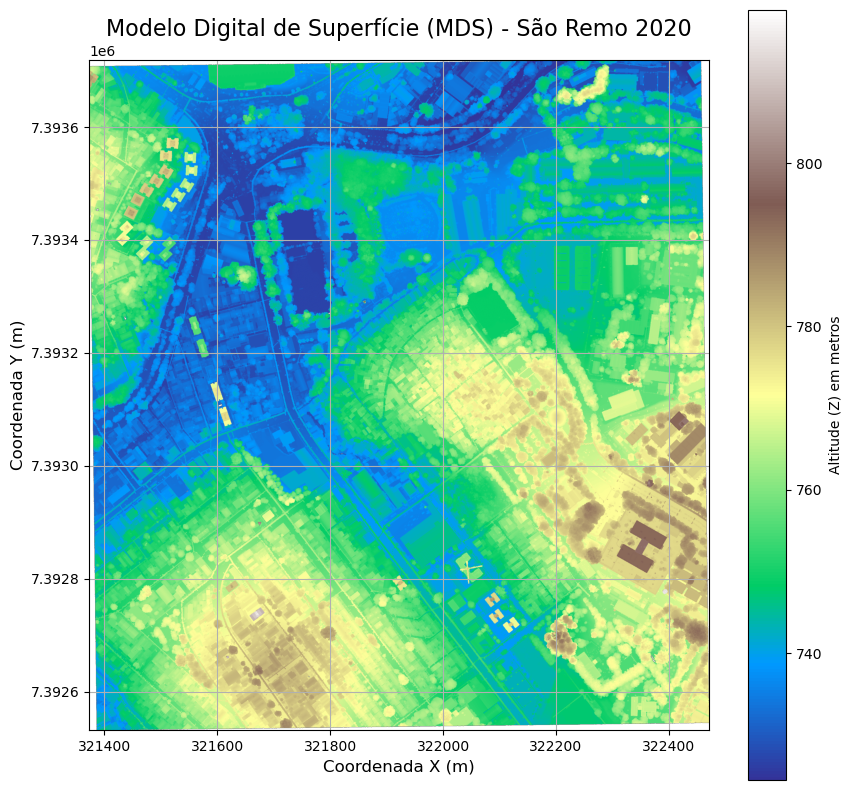

In [3]:
# Plota o "resultados/MDS_Sao_Remo_2020_max_altitude.tif"
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

with rasterio.open("resultados/MDS_Sao_Remo_2020_max_altitude.tif") as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, cmap='terrain')
    ax.set_title('Modelo Digital de Superfície (MDS) - São Remo 2020', fontsize=16)
    plt.xlabel('Coordenada X (m)', fontsize=12)
    plt.ylabel('Coordenada Y (m)', fontsize=12)
    plt.colorbar(ax.images[0], ax=ax, label='Altitude (Z) em metros')
    plt.grid(True)
    plt.show()


/Users/fernandogomes/miniconda3/envs/pdal/lib/python3.12/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read(


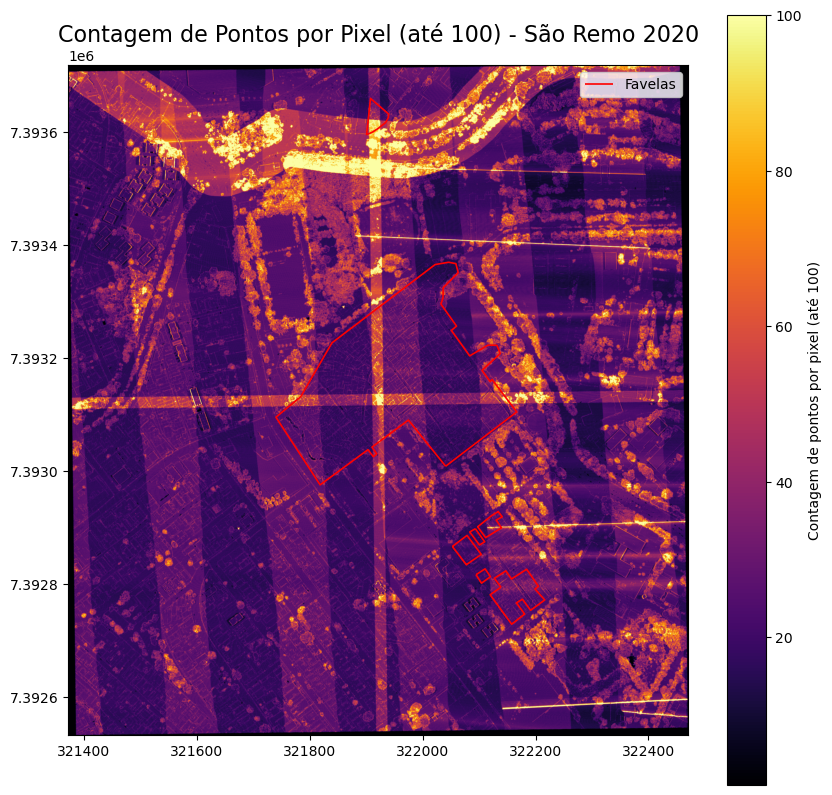

In [4]:
# Plota o histograma e ajusta o color ramp do raster para destacar até ~100 pontos por pixel
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import box

# Define um color ramp ajustado para o intervalo de interesse
vmin, vmax = 1, 100  # ignora zeros, destaca até 100 pontos/pixel
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

with rasterio.open("resultados/MDS_Sao_Remo_2020_max_altitude.tif") as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    # Plota a segunda banda (contagem de pontos por pixel) com color ramp ajustado
    show((src, 2), ax=ax, cmap='inferno', norm=norm)
    ax.set_title('Contagem de Pontos por Pixel (até 100) - São Remo 2020', fontsize=16)

    # Carrega o arquivo das favelas
    gdf_favelas = gpd.read_file('../downloads/SIRGAS_GPKG_favela.gpkg')

    # Reprojeta para o CRS do raster (se necessário)
    if gdf_favelas.crs != src.crs:
        gdf_favelas = gdf_favelas.to_crs(src.crs)

    # Cria um polígono com a extensão (bounding box) do raster
    raster_bounds = box(*src.bounds)

    # Clipa as favelas para pegar só o que intersecta a área do raster
    gdf_clip = gdf_favelas[gdf_favelas.intersects(raster_bounds)]

    # Desenha os polígonos clipados
    gdf_clip.boundary.plot(ax=ax, edgecolor='red', linewidth=1.2, label="Favelas")

    # Barra de cor ajustada
    cbar = plt.colorbar(ax.images[0], ax=ax, label='Contagem de pontos por pixel (até 100)')
    plt.legend()
    plt.show()

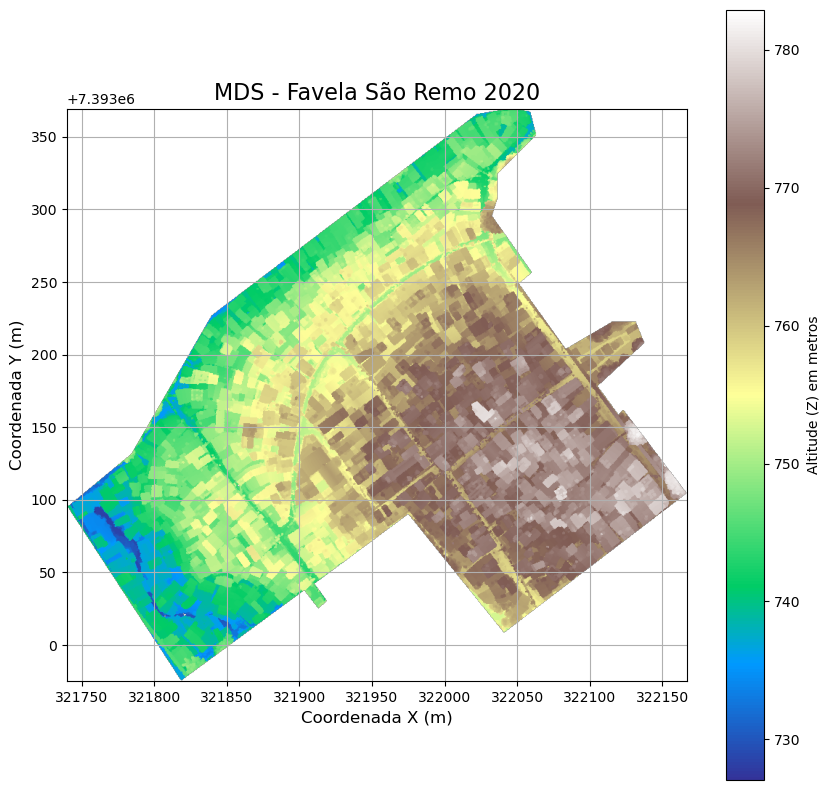

In [5]:
# retorna a feição de gdf_favelas cujo fv_nome inicia com "São Remo"
gdf_favela_sao_remo = gdf_favelas[gdf_favelas['fv_nome'].str.startswith("São Remo")]

# recorta o raster para a área da favela São Remo
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box

# recorta o raster para a área da favela São Remo
with rasterio.open("resultados/MDS_Sao_Remo_2020_max_altitude.tif") as src:
    out_image, out_transform = mask(src, gdf_favela_sao_remo.geometry, crop=True)

# exclui os valores -9999 (no data) para não ser exibido no plot
out_image = np.where(out_image == src.nodata, np.nan, out_image)

# plota o raster recortado
fig, ax = plt.subplots(figsize=(10, 10))
show(out_image[0], transform=out_transform, ax=ax, cmap='terrain')
ax.set_title('MDS - Favela São Remo 2020', fontsize=16)
plt.xlabel('Coordenada X (m)', fontsize=12)
plt.ylabel('Coordenada Y (m)', fontsize=12)
plt.colorbar(ax.images[0], ax=ax, label='Altitude (Z) em metros')
plt.grid(True)
plt.show()  

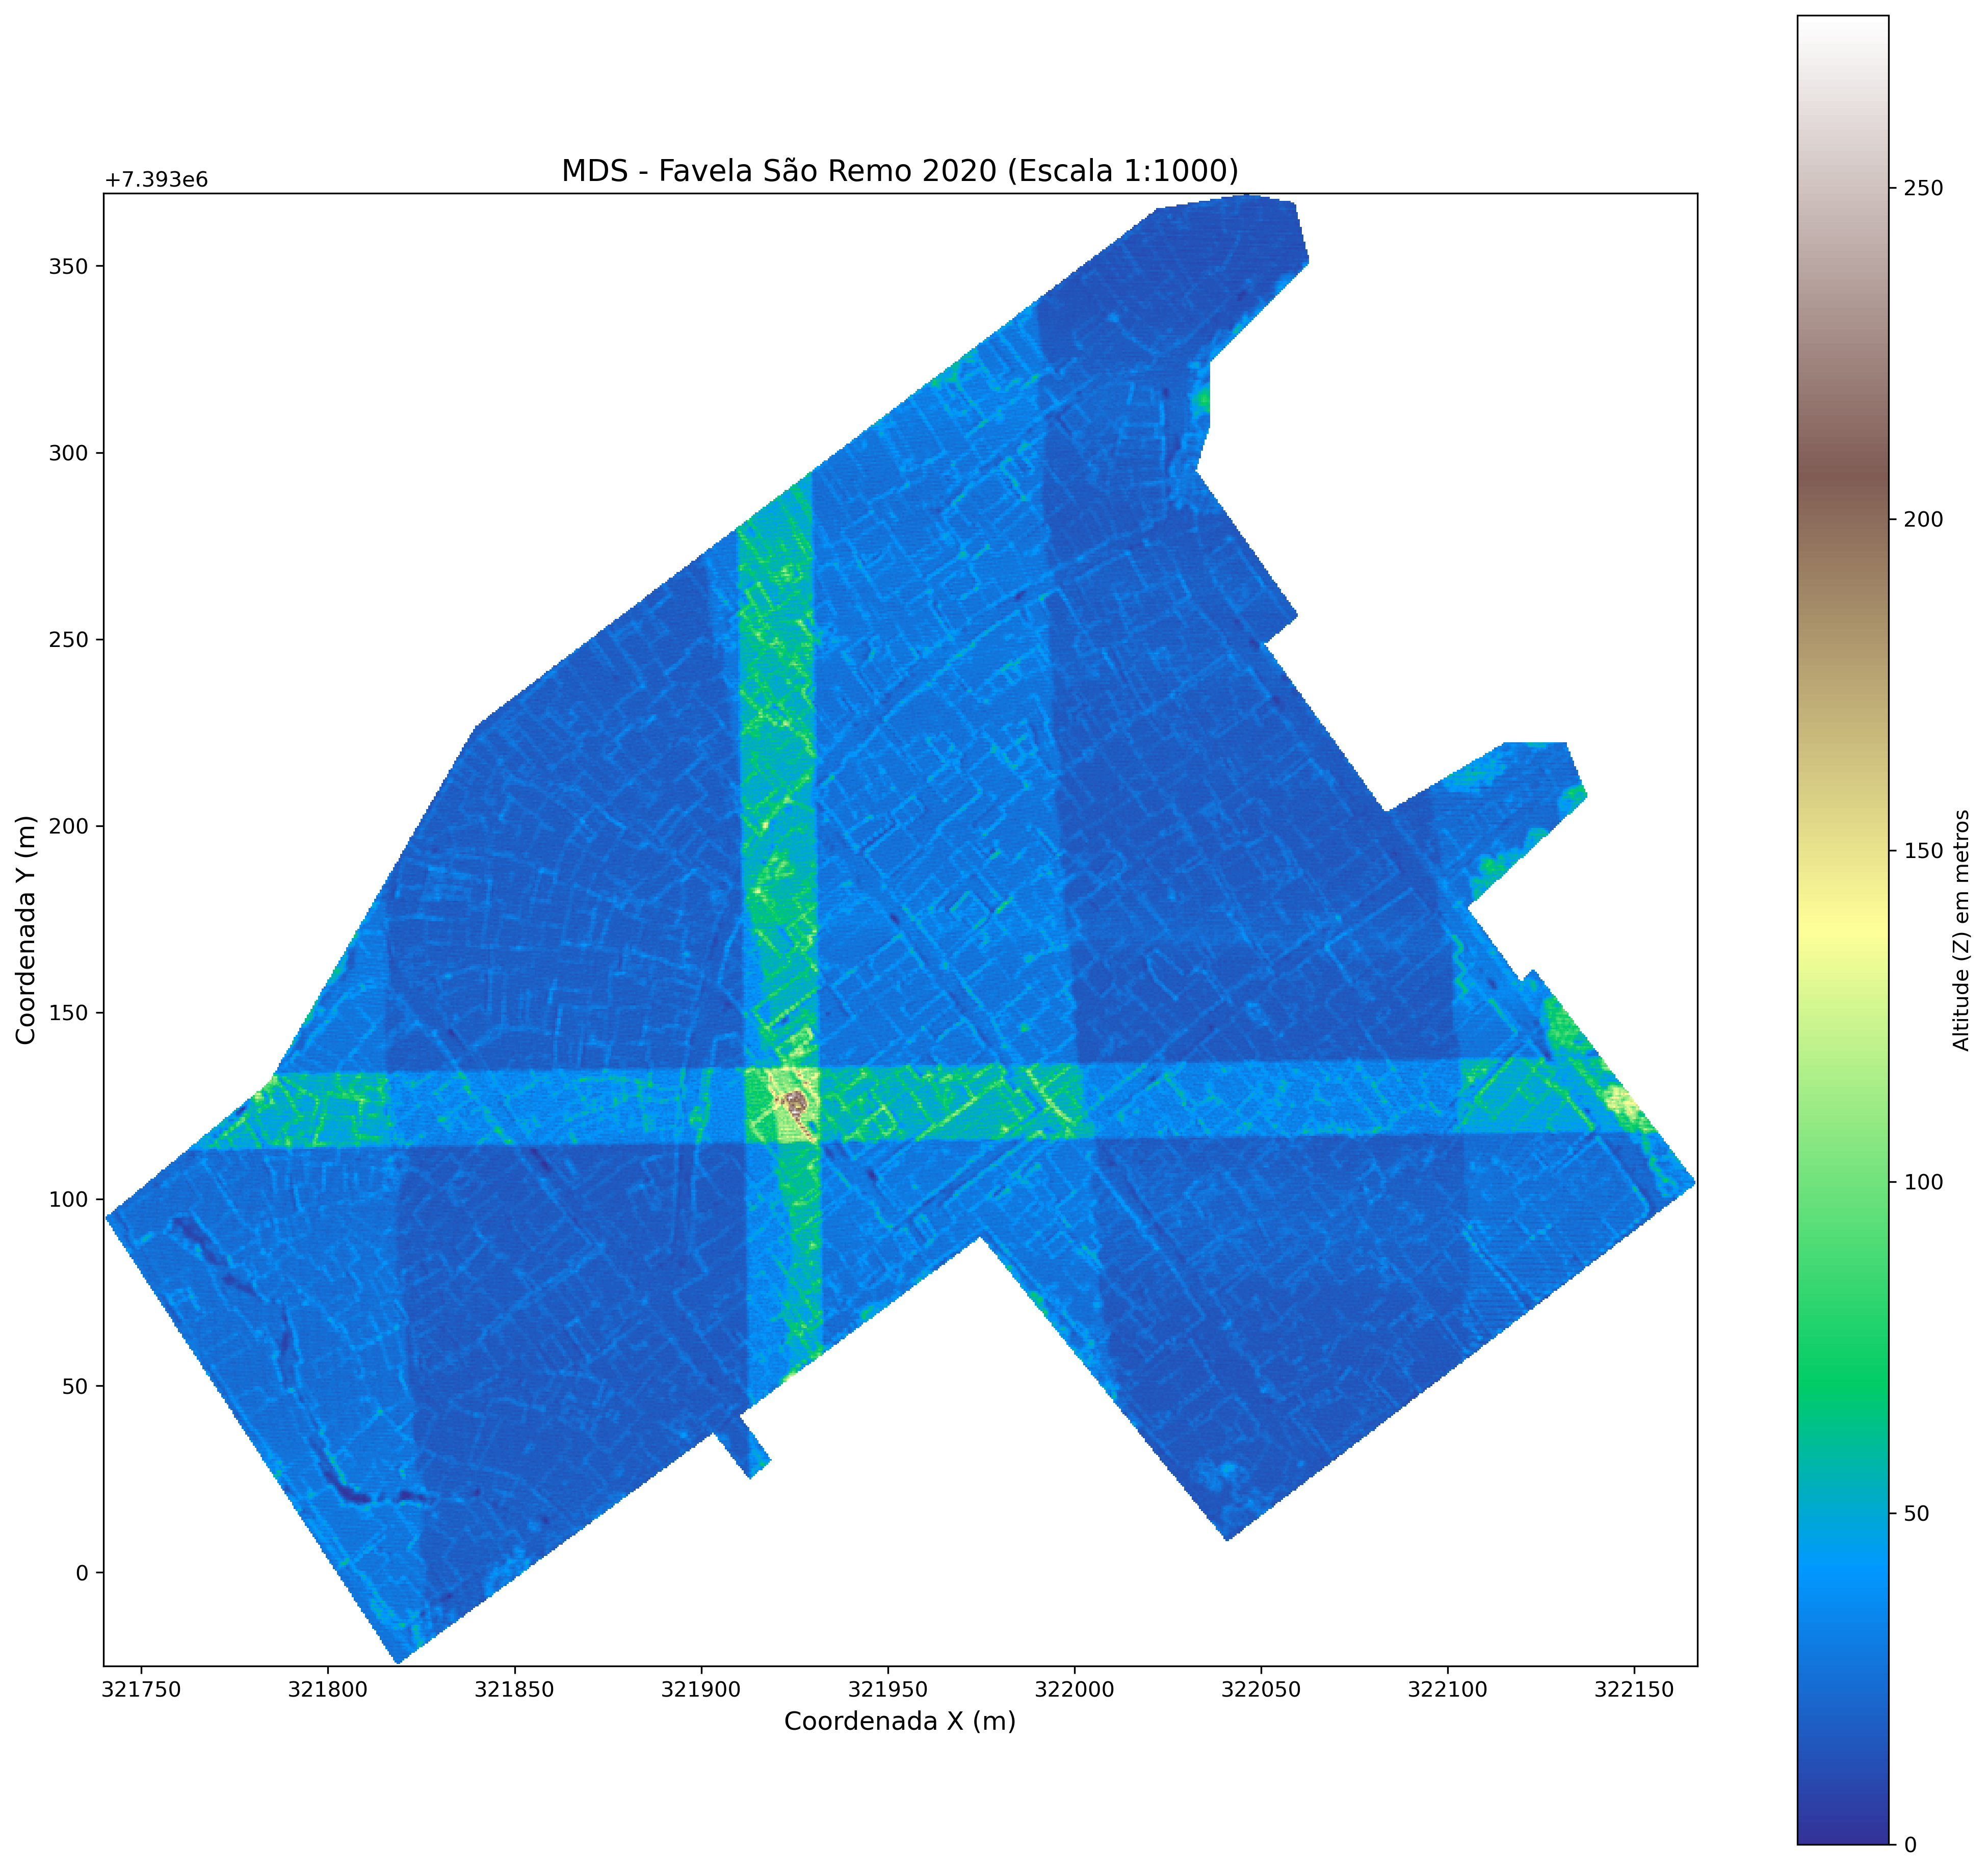

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import geopandas as gpd

with rasterio.open("resultados/MDS_Sao_Remo_2020_max_altitude.tif") as src:
    out_image, out_transform = mask(src, gdf_favela_sao_remo.geometry, crop=True)
    out_image = np.where(out_image == src.nodata, np.nan, out_image)

    # --- Escala 1:1000 ---
    resolucao = src.res[0]   # 0.5 m/pixel
    pixel_size_mm = resolucao * 1000 / 1000  # 0.5 m → 0.5 mm
    pixel_size_inch = pixel_size_mm / 25.4

    # Dimensões em pixels do recorte
    height, width = out_image.shape[1:]
    fig_width = width * pixel_size_inch
    fig_height = height * pixel_size_inch

    # Plot com figsize ajustado
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
    show(out_image[1], transform=out_transform, ax=ax, cmap='terrain')

    ax.set_title('MDS - Favela São Remo 2020 (Escala 1:1000)', fontsize=14)
    plt.xlabel('Coordenada X (m)', fontsize=12)
    plt.ylabel('Coordenada Y (m)', fontsize=12)
    cbar = plt.colorbar(ax.images[0], ax=ax, label='Altitude (Z) em metros')

    plt.show()

    # (opcional) exporta em PDF/PNG já pronto
    # plt.savefig("sao_remo_escala1000.pdf", dpi=300)
